# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries

import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Loading the Data Set

df = "mini_sparkify_event_data.json"
df = spark.read.json(df)

# Cleaning the Dataset
df = df.drop(*['artist','song','firstName', 'lastName', 'id_copy'])             # dropping some irrelevant columns
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])                   # droppping some potential NA values
df = df.filter(df.userId!='').orderBy(["userId", "ts"], ascending=[True, True]) # filtering out the invalid Ids
df = df.withColumn("userId", df["userId"].cast(IntegerType()))                  # case userId column to integer
 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
# Defining the Churn
# These are Customers landing on the Cancellation Confirmation page
cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
df = df.withColumn("churn", cancelation("page"))
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("churn", Fsum("churn").over(window))


##Some new columns were made in this step to make the data exploration easier, the Feature engineering step comes later

# Making the level_shift Column
# This column tells us how many times did the customer switched from paid to free service
window1 = Window.partitionBy().orderBy(["userId", "ts"])
df = df.withColumn("level_shift", (df.level!=F.lag(df.level).over(window1)) | (df.userId!=F.lag(df.userId).over(window1)))
df=df.fillna({'level_shift':0})
df= df.withColumn("level_shift", F.when(df["level_shift"]==False, 0).otherwise(1))


# Making the last_ts column
# This column will help us to select only records that happened in the last 2 weeks of customer activity
# The idea is that customer behavior should be different shortly before the churn happened

df= df.withColumn("ts", df.ts/1000)                        # trimming the last three zeros from the UNIX time (miliseconds)
df= df.withColumn("registration", df.registration/1000)

window2 = Window.partitionBy("userId")
df= df.withColumn("last_ts", F.max('ts').over(window2))
df=df.filter(df.last_ts - df.ts < 1300000) #2592000         # this is the approx number of seconds in a 2 week period


# Making the Columns: pages_per_session, diff_time
# pages_per_session is number of pages per session
# diff_time is a number of days since a specific page was visited

window3 = Window.partitionBy(["userId", "sessionId"])
df= df.withColumn("pages_per_session", F.max('ItemInSession').over(window3))
df = df.withColumn("ts_time",F.to_timestamp(df.ts))                    #  unix to datetime
df = df.withColumn("last_ts_time",F.to_timestamp(df.last_ts))          # unix to datetime

df = df.withColumn("diff_time",F.datediff(df.last_ts_time, df.ts_time))  # how many days ago was the page visited

df=df.orderBy(["userId", "ts"], ascending=[True, True])

df.createOrReplaceTempView('data');                                    # Create a Temp Table to be used foe SQL queries

In [6]:
# Data preview

df.limit(2).toPandas()

,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,...,ts,userAgent,userId,churn,level_shift,last_ts,pages_per_session,ts_time,last_ts_time,diff_time
0,Logged In,F,0,250.82730,paid,"Raleigh, NC",PUT,NextSong,1.536800e+09,1639,...,1.542150e+09,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1.542839e+09,192,2018-11-13 22:51:43,2018-11-21 22:30:04,8
1,Logged In,F,1,148.55791,paid,"Raleigh, NC",PUT,NextSong,1.536800e+09,1639,...,1.542150e+09,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1.542839e+09,192,2018-11-13 22:55:53,2018-11-21 22:30:04,8


In [7]:
# The column "page" seems to be most informative in the whole dataset
# It shows which pages of the service were visited by users, timestamp is also provided
# This column can be used to engineer useful features

df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         16|
|         Thumbs Down|        917|
|                Home|       3701|
|           Downgrade|        821|
|         Roll Advert|       1308|
|              Logout|       1201|
|       Save Settings|        126|
|Cancellation Conf...|         52|
|               About|        183|
|            Settings|        607|
|     Add to Playlist|       2380|
|          Add Friend|       1613|
|            NextSong|      85017|
|           Thumbs Up|       4479|
|                Help|        537|
|             Upgrade|        154|
|               Error|         80|
|      Submit Upgrade|         37|
+--------------------+-----------+



In [8]:
df.printSchema();

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- churn: long (nullable = true)
 |-- level_shift: integer (nullable = false)
 |-- last_ts: double (nullable = true)
 |-- pages_per_session: long (nullable = true)
 |-- ts_time: timestamp (nullable = true)
 |-- last_ts_time: timestamp (nullable = true)
 |-- diff_time: integer (nullable = true)



In [9]:
# Investigation if there are differences between churned and non-churned users

# label             - 0 if non_churned, 1 if churned
# song_count        - avg number of songs played by churned/non_churned users
# error             - avg number of errors occuring 
# friends           - avg number of "friends" on thhe application
# playlist_count    - avg number of visits to the Playlist page
# thumbs_up         - avg number of clicking the 'thumbs up'
# thumbs_down       - avg number of clicking the 'thumbs down'
# downgrade         - avg number of visits to the downgrade page
# count_session_dist- avg number of sessions made
# count_diff_time   - avg number of days (in the last two weeks) in which the user used the app
# pages per session - avg numbers of pages (or any activity or changes) per session
# duration          - avg number of days since the user joined (division with 86400 as a proxy of seconds within a day)
# level_shift       - avg number of level changes (free, paid) per customer
# usage_time        - avg total time spent using the app


stats = spark.sql(" WITH prep as( \
SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
avg(distinct pages_per_session)                                     as pages_per_session, \
(max(ts) - min(registration))/86400                                 as duration, \
sum(level_shift)                                                    as level_shift, \
sum(length)                                                         as usage_time \
FROM data \
GROUP BY userId) \
SELECT label, \
count(label)             as cnt, \
avg(song_count)          as song_count, \
avg(error)               as error, \
avg(friends)             as friends, \
avg(playlist_count)      as playlist_count, \
avg(thumbs_up)           as thumbs_up, \
avg(thumbs_down)         as thumbs_down, \
avg(downgrade)           as downgrade, \
avg(count_session_dist)  as count_session_dist, \
avg(count_diff_time)     as count_diff_time, \
avg(pages_per_session)   as pages_per_session, \
avg(duration)            as duration, \
avg (level_shift)        as level_shift, \
avg(usage_time)          as usage_time \
FROM prep \
GROUP BY label")

# We can see that for most dimensions/features there are differences between churned and non-churned users
stats.toPandas()

,label,cnt,song_count,error,friends,playlist_count,thumbs_up,thumbs_down,downgrade,count_session_dist,count_diff_time,pages_per_session,duration,level_shift,usage_time
0,0,173,360.803468,0.335260,7.098266,10.017341,19.132948,3.560694,3.358382,4.583815,4.786127,106.386183,86.620619,0.265896,89989.124825
1,1,52,434.576923,0.423077,7.403846,12.442308,22.480769,5.788462,4.615385,5.596154,5.480769,92.803856,57.305993,0.730769,108072.679578


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
# Feature Enigneering

# Based on the previous analysis, all 14 investigated features will be included. 
# Here I am making a Temp Table which holds all the features.
# The temp table will be used as model input
# All data is aggregated per userId


features = spark.sql("SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
round(avg(distinct pages_per_session),0)                            as pages_per_session, \
round((max(ts) - min(registration))/86400,0)                        as duration, \
round(sum(level_shift),0)                                           as level_shift, \
round(sum(length),0)                                                as usage_time \
FROM data \
GROUP BY userId");

features.createOrReplaceTempView('features');
features=features.na.drop()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [15]:

# Train Test Split
training, test = features.randomSplit([0.8, 0.2])


# Make VectorAssembler - this is a Pypark specific step
# All input features must be in one column before feeding into the model

assembler = VectorAssembler(inputCols=["userId","song_count","error","friends","playlist_count", \
                                       "thumbs_up","thumbs_down","downgrade", "count_session_dist",\
                                       "count_diff_time","pages_per_session", "duration","level_shift",\
                                       "usage_time"], \
                            outputCol="inputFeatures")



# Normalize Data
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")


# Spark supports most common classification methods (https://spark.apache.org/docs/latest/ml-classification-regression.html)
# I decided for the following three:

lr=LogisticRegression()
gbt = GBTClassifier()
rf= RandomForestClassifier()


# Building pipelines
pipeline1=Pipeline(stages=[assembler, scaler, lr])
pipeline2=Pipeline(stages=[assembler, scaler, gbt])
pipeline3=Pipeline(stages=[assembler, scaler, rf])

#### Logistic Regresion

In [16]:
# metric chosen is f1 (we want to catch true positives (churn customers), but
# we do not want to waste money on false positives (investing in retaining non-churn customers, which are loyal anyway)
# Note that Recall might also be justified to use here (if the cost of false positives is low)


paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\
.build()


evaluator=MulticlassClassificationEvaluator(metricName="f1")
#evaluator=BinaryClassificationEvaluator( metricName="areaUnderROC")

# Crossvalidator (https://spark.apache.org/docs/2.1.3/api/python/_modules/pyspark/ml/tuning.html)

crossval= CrossValidator(estimator=pipeline1,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator , 
                         numFolds=3
                        )

cvModel1=crossval.fit(training) 
evaluator.evaluate(cvModel1.transform(test))

#cvModel1.subModels() 
#cvModel1.avgMetrics

0.7433574879227053

#### Gradient boosted tree classifier

In [17]:


# Specify multiple parameters in the paramgrid, in case you have enough processing power 
paramgrid1 =ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline2,  
                         estimatorParamMaps=paramgrid1,
                         evaluator=evaluator, 
                         numFolds=3
                        )

cvModel2=crossval.fit(training) 
evaluator.evaluate(cvModel2.transform(test))

0.7719361248773013

#### Random Forest

In [18]:

# Specify multiple parameters in the paramgrid, in case you have enough processing power
paramgrid2 =ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")
#evaluator=BinaryClassificationEvaluator( metricName="areaUnderROC")

crossval= CrossValidator(estimator=pipeline3,  
                         estimatorParamMaps=paramgrid2,
                         evaluator=evaluator, 
                         numFolds=3
                        )

cvModel3=crossval.fit(training) 
evaluator.evaluate(cvModel3.transform(test))

0.7697849825509401

In [19]:
predictions=cvModel2.transform(test)
#predictions.limit(2).toPandas()

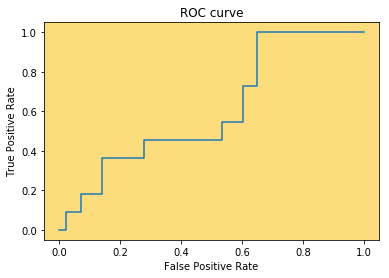

In [20]:
# Gradient Boosted Tree Classifier seems to be the winner model, let us plot its ROC Curve
 
#predictions=cvModel2.transform(test)
def roc(ax, predictions, labels, title='ROC curve'):
    pp = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    tpr, fpr, _ = roc_curve(labels, pp)
    ax.plot(tpr, fpr)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    
#plt.clf() # to be used for AWS EMR

labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
roc(ax, predictions,labels)

#%matplot plt # to be used for AWS EMR

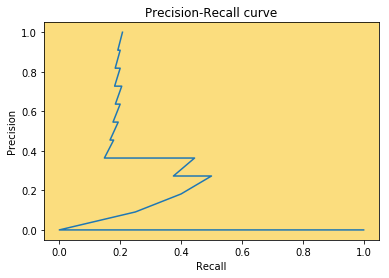

In [21]:
# Gradient Boosted Tree Classifier seems to be the winner model, let us plot its Precision-Recall Curve
 
predictions=cvModel2.transform(test)
def pr(ax, predictions, labels, title='Precision-Recall curve'):
    pp = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    pr, rc, _ = precision_recall_curve(labels, pp)
    ax.plot(pr, rc)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    
#plt.clf() # to be used for AWS EMR

labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
pr(ax, predictions,labels)

#%matplot plt # to be used for AWS EMR

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.